In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasdaq100-stock-price-data/NASDAQ_100_Data_From_2010.csv


In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader

from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#import warnings
import warnings
warnings.filterwarnings('ignore')

In [69]:
try:
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf
except:
    !pip install --upgrade tensorflow
    !pip install keras
    !pip install --ignore-installed --upgrade tensorflow-gpu
    !pip install wrapt==1.11.1
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf

In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [71]:
!pip install yfinance



In [72]:
from pandas_datareader import data
import yfinance as yfin

yfin.pdr_override()

stocks = data.get_data_yahoo('MSFT', start='2020-01-14', end='2023-01-14')

[*********************100%***********************]  1 of 1 completed


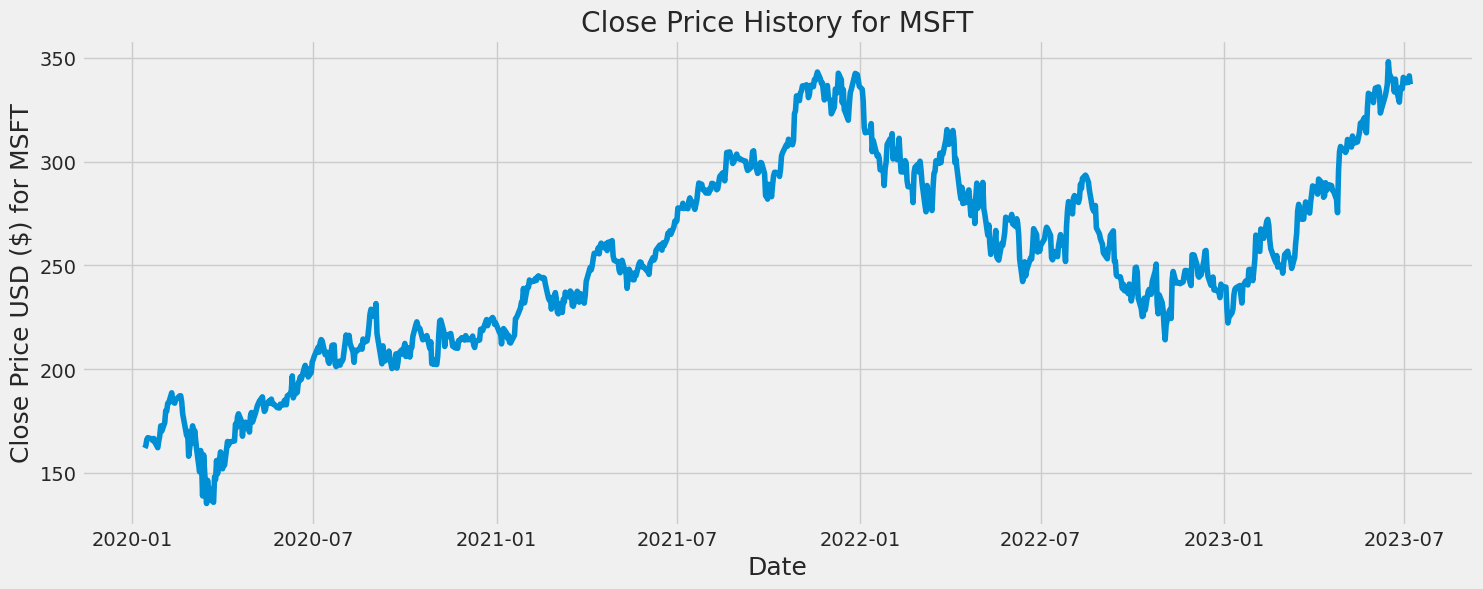

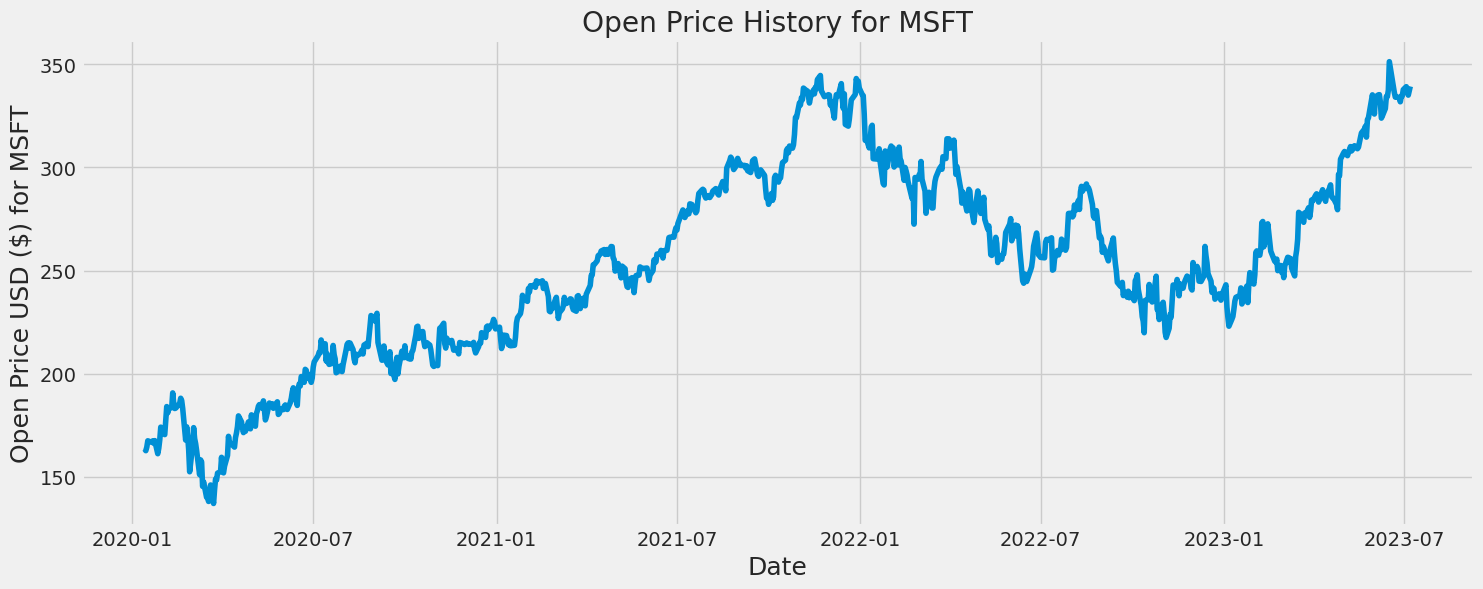

In [73]:
def collect_data(stock):
    stocks = yfin.download(stock, start='2020-01-14', end=datetime.now(), progress=False)
    return stocks

def plot_close_val(data_frame, column, stock):
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock )
    plt.plot(data_frame[column])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + ' Price USD ($) for ' + stock, fontsize=18)
    plt.show()
    
#Testing functions
stock = 'MSFT'
df = collect_data(stock)

plot_close_val(df, 'Close', stock)
plot_close_val(df, 'Open',  stock)

In [74]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close' column 
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .90 ))
    return data, dataset, training_data_len

In [75]:
#Testing function
training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df

In [76]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler, scaled_data = scale_the_data(training_dataset_np)

In [77]:
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(70, len(train_data)):
        x_train.append(train_data[i-70:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 71:
            #print(x_train)
            #print(y_train)
            print('.')
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return x_train, y_train

In [78]:
#Testing function
x_train,y_train = split_train_dataset(training_data_len)

.
.


In [79]:
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model 

#Test the function
lstm_model = build_lstm_model(x_train,y_train)

719/719 [==============================] - 26s 32ms/step - loss: 0.0042


In [80]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):
    # Create the testing data set
    
    test_data = scaled_data[training_data_len - test_data_len: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
     # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions, rmse)

In [81]:
#Test the function
TEST_DATA_LENGTH = 70
x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

3/3 [==============================] - 1s 32ms/step


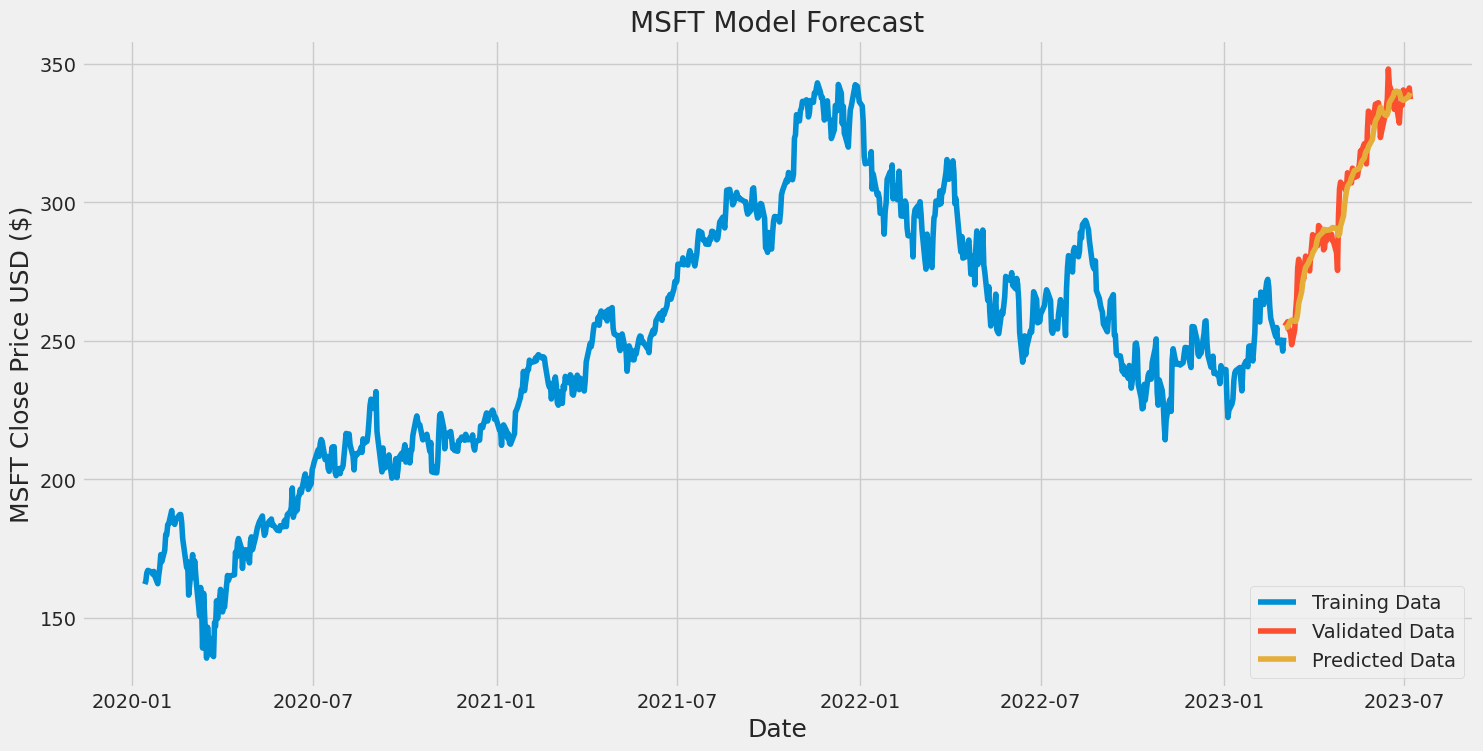

In [82]:
def plot_predictions(stock, data, training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,8))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid
    
#Test the function
valid = plot_predictions('MSFT',data, training_data_len)

In [83]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-03-03,255.289993,254.739044
2023-03-06,256.869995,254.963684
2023-03-07,254.149994,255.858749
2023-03-08,253.699997,256.644318
2023-03-09,252.320007,257.232452
...,...,...
2023-06-30,340.540009,336.803802
2023-07-03,337.989990,337.456146
2023-07-05,338.149994,338.065430


Let us evaluate for all stocks starting with'A' in NASDAQ


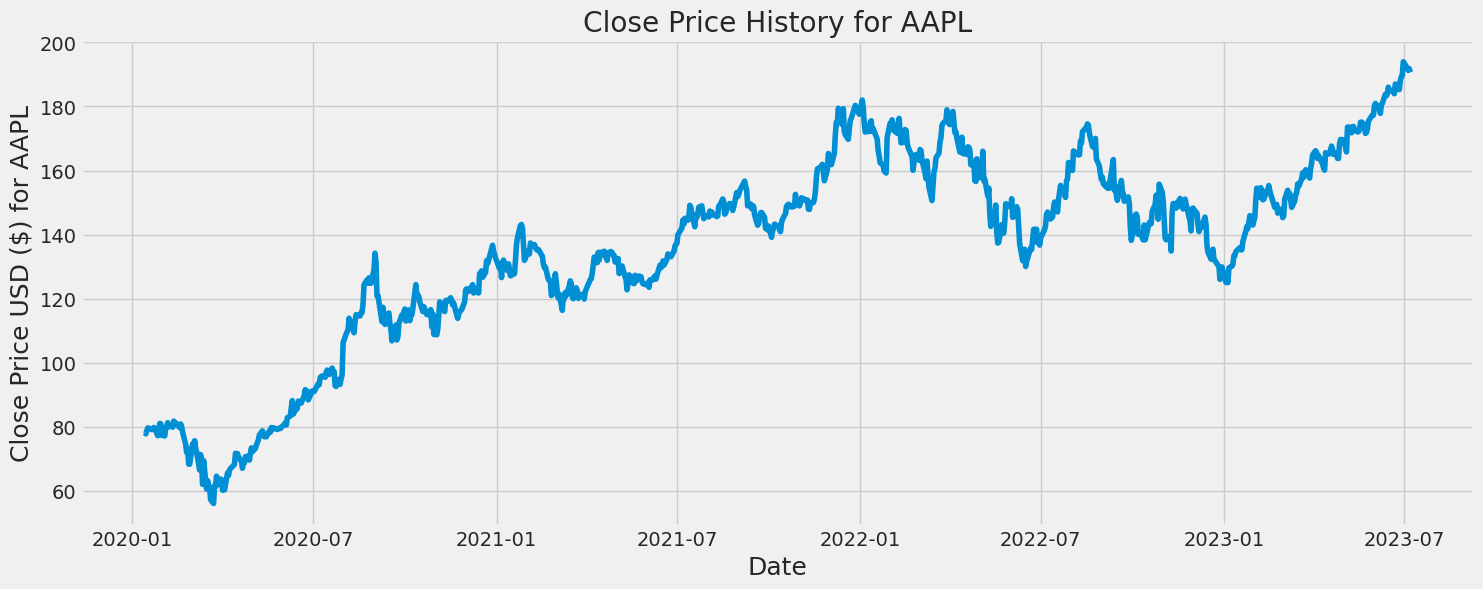

.
.
3/3 [==============================] - 1s 33ms/step


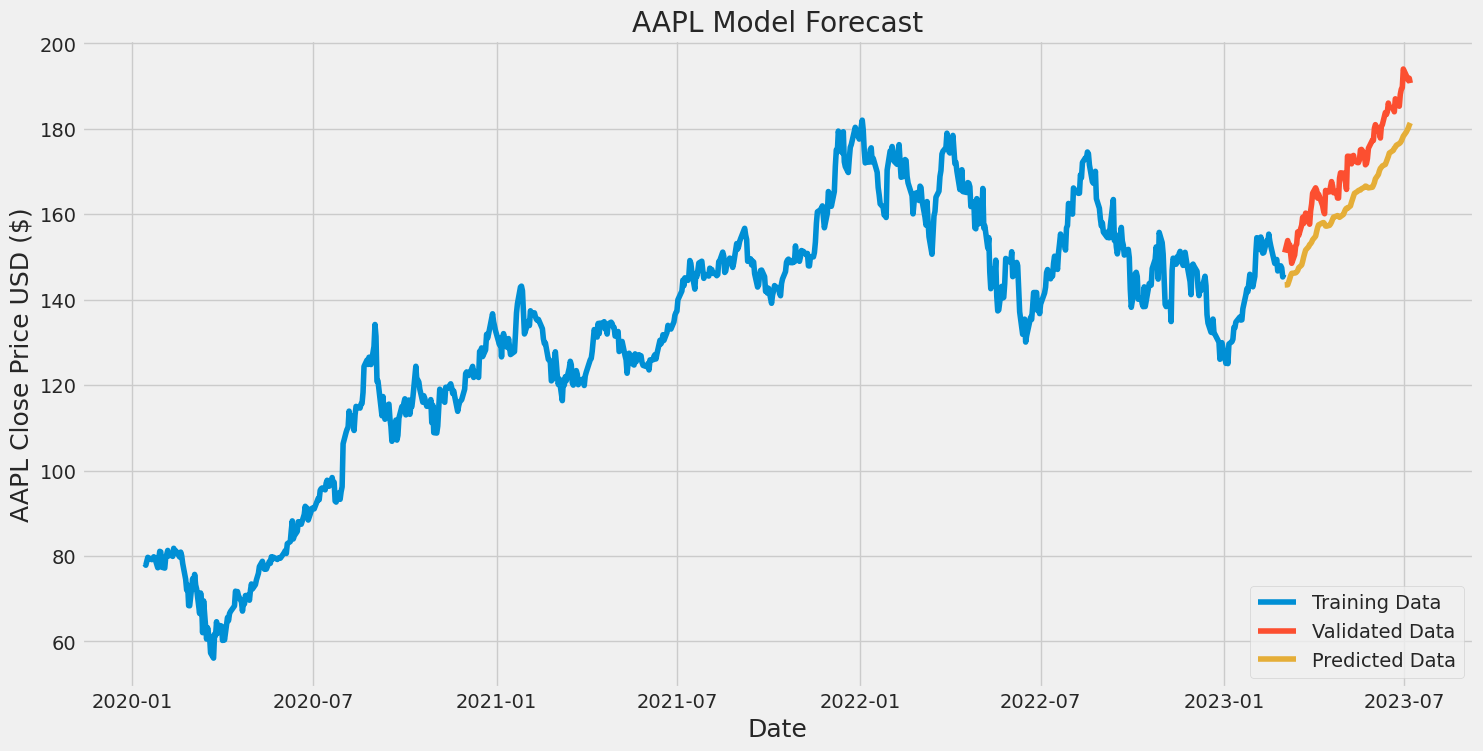

Test RMSE: 8.982


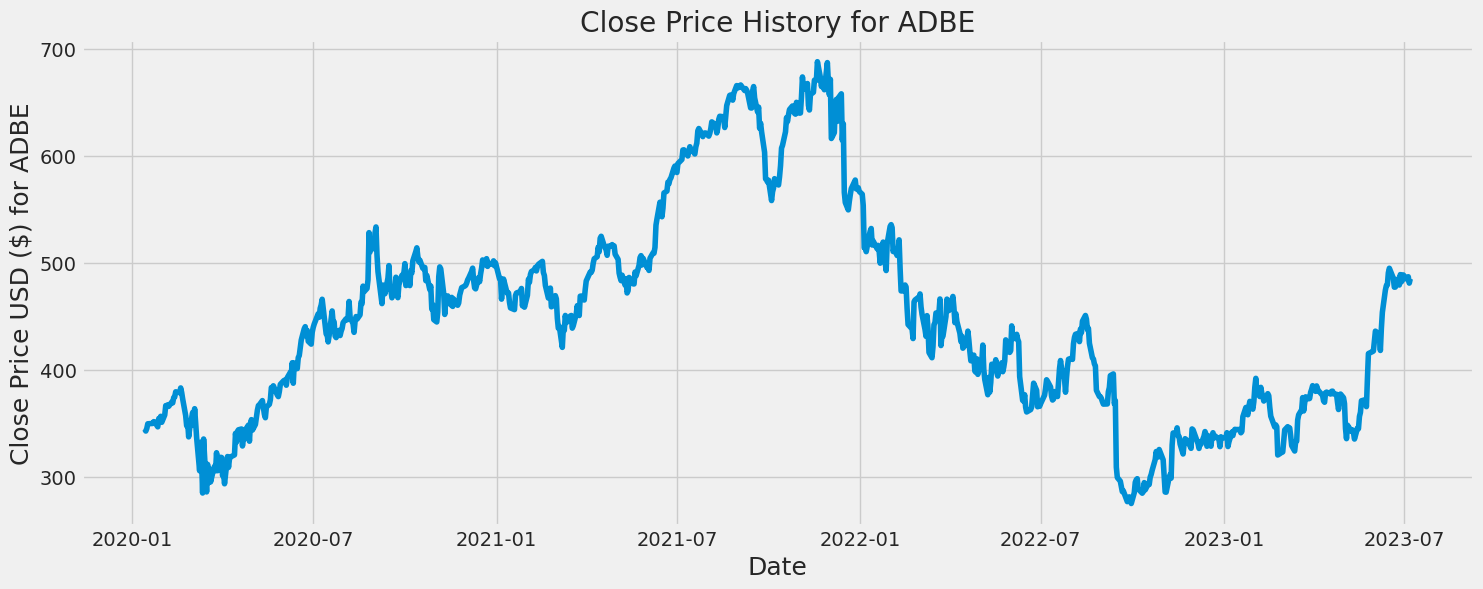

.
.
3/3 [==============================] - 1s 32ms/step


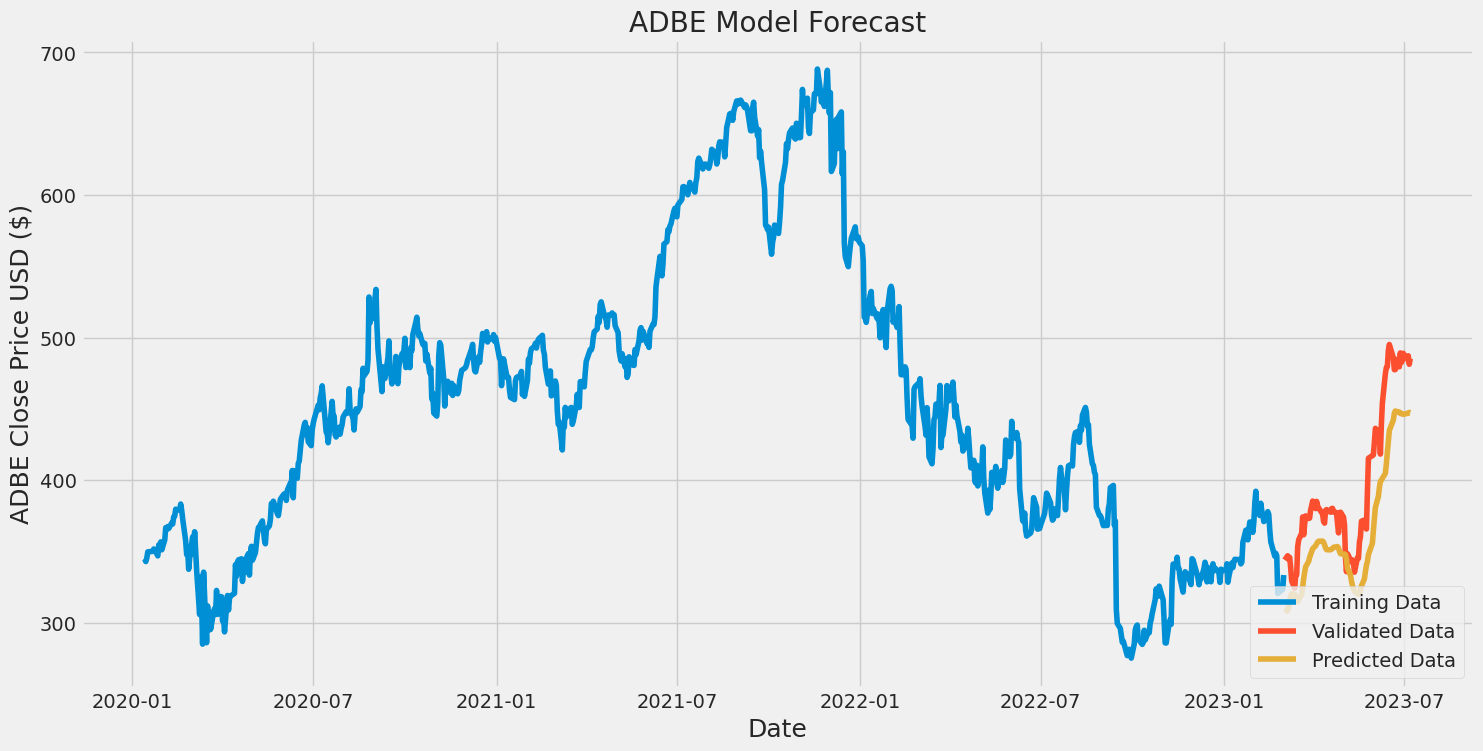

Test RMSE: 35.710


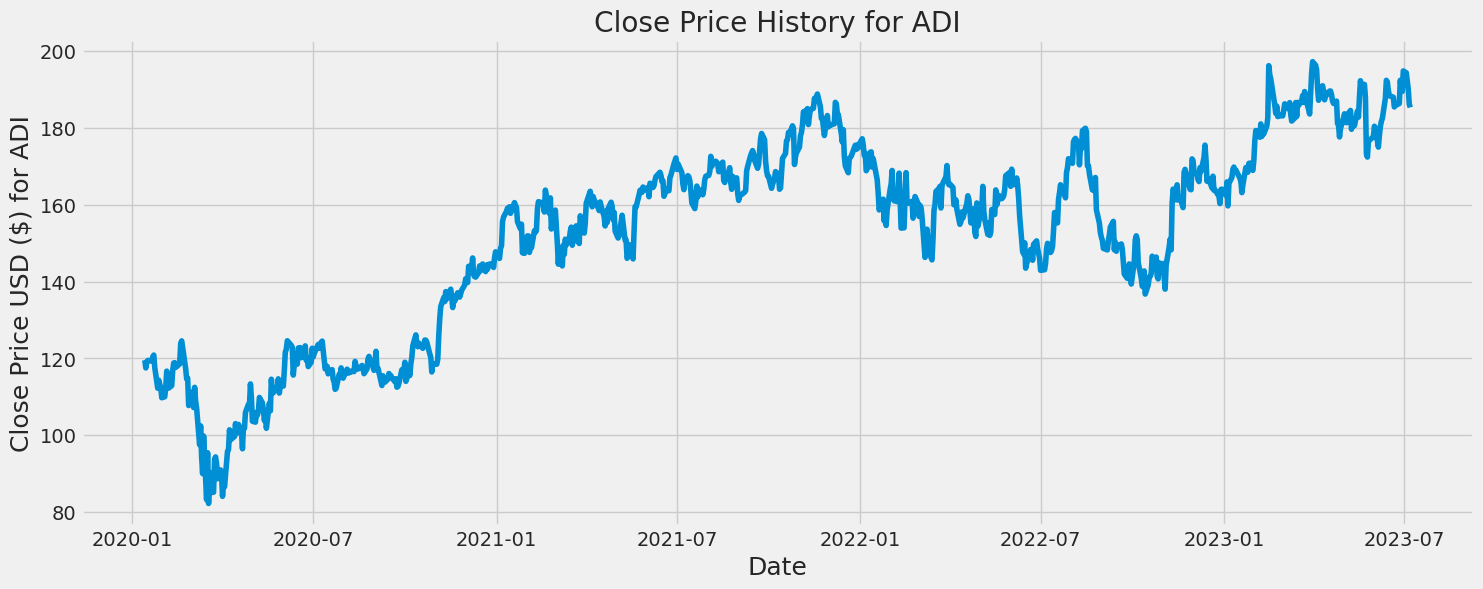

.
.
3/3 [==============================] - 1s 28ms/step


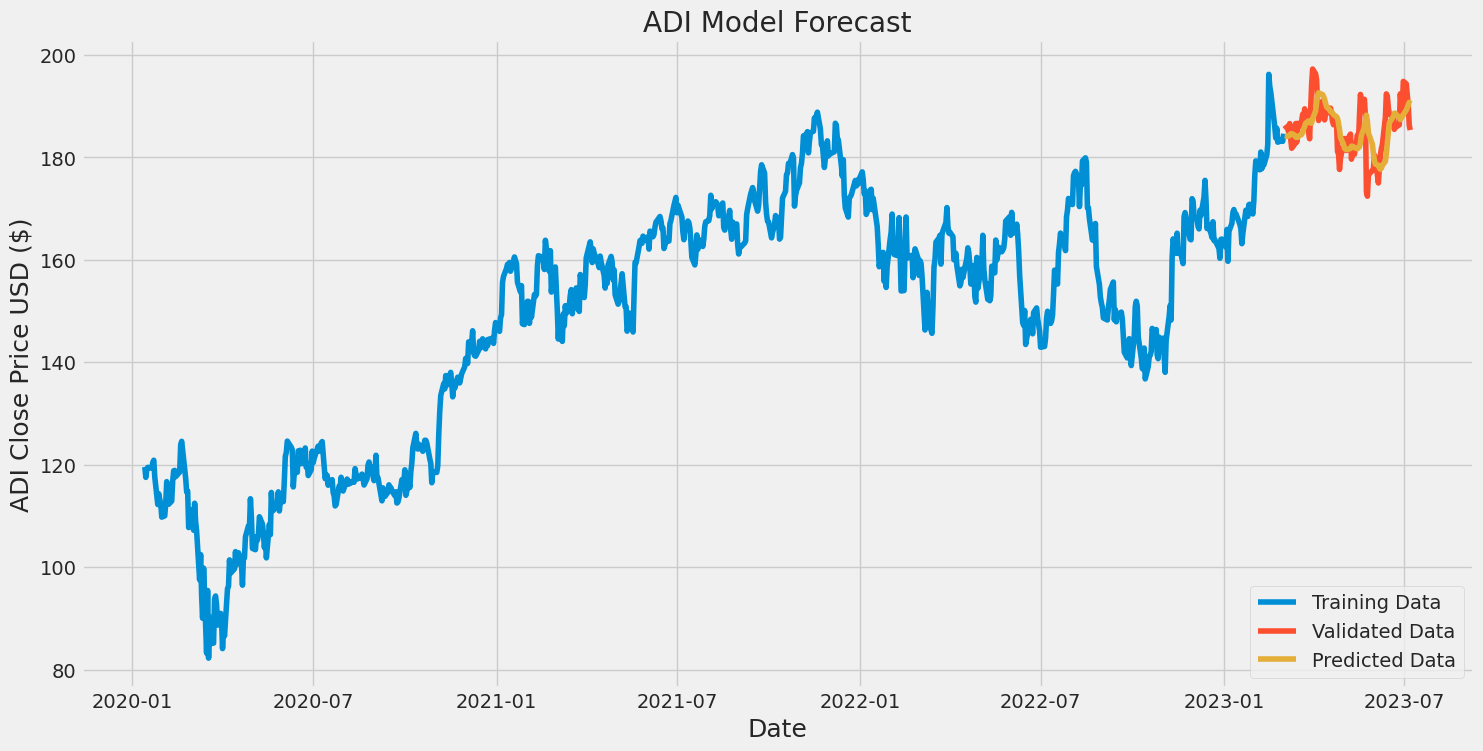

Test RMSE: 4.618


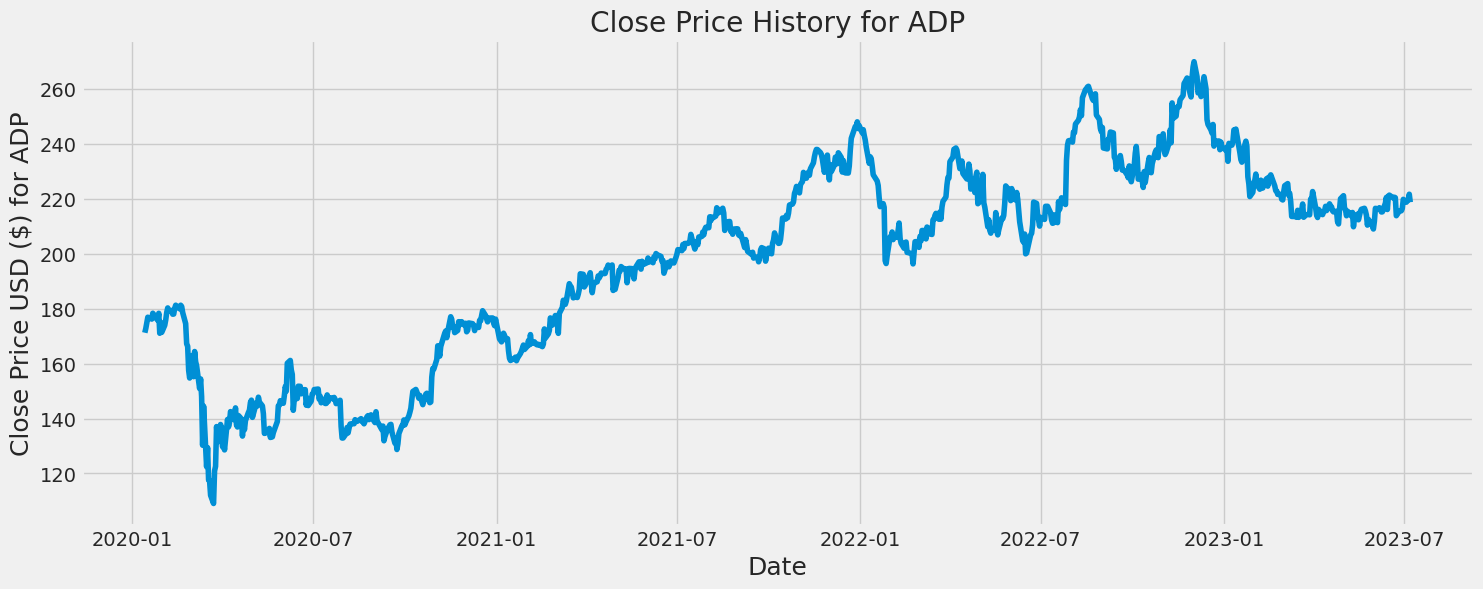

.
.
3/3 [==============================] - 1s 33ms/step


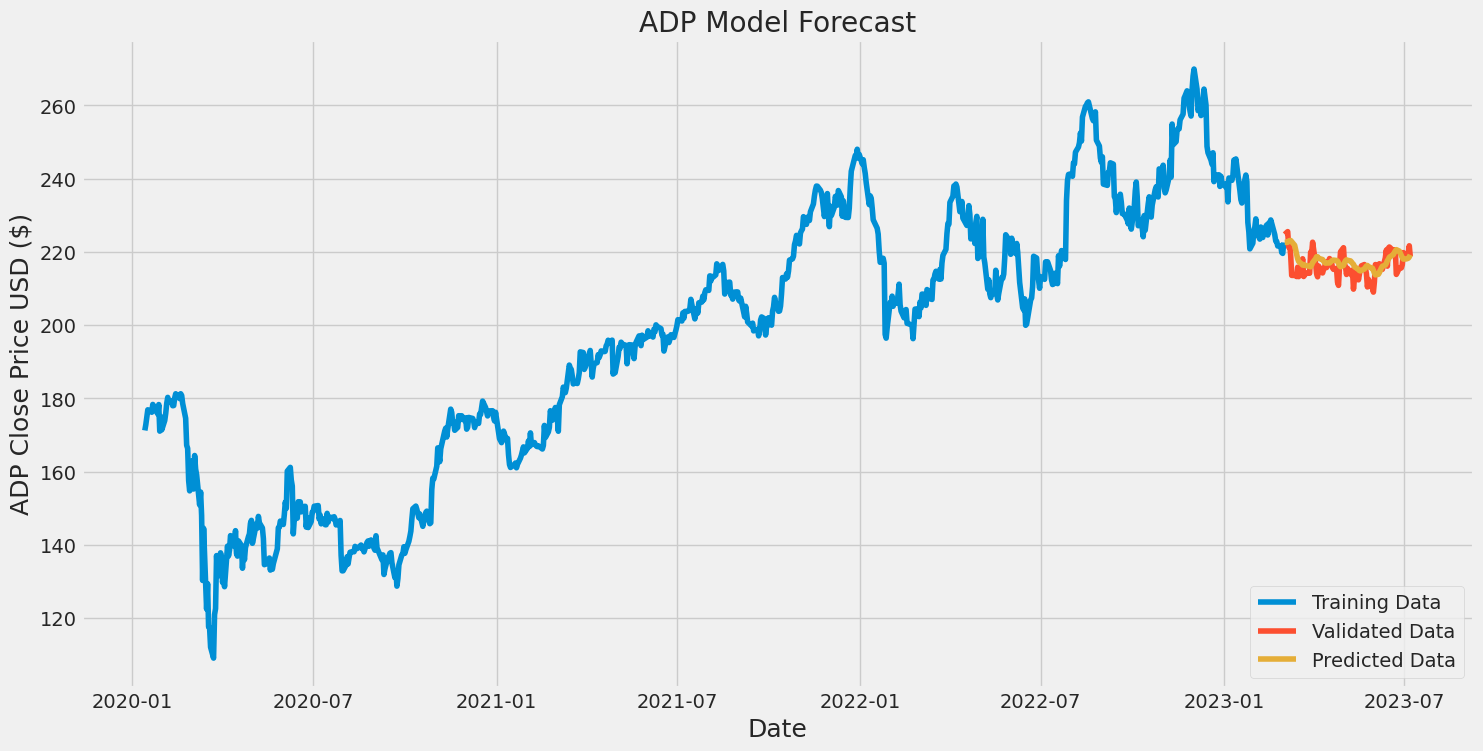

Test RMSE: 3.401


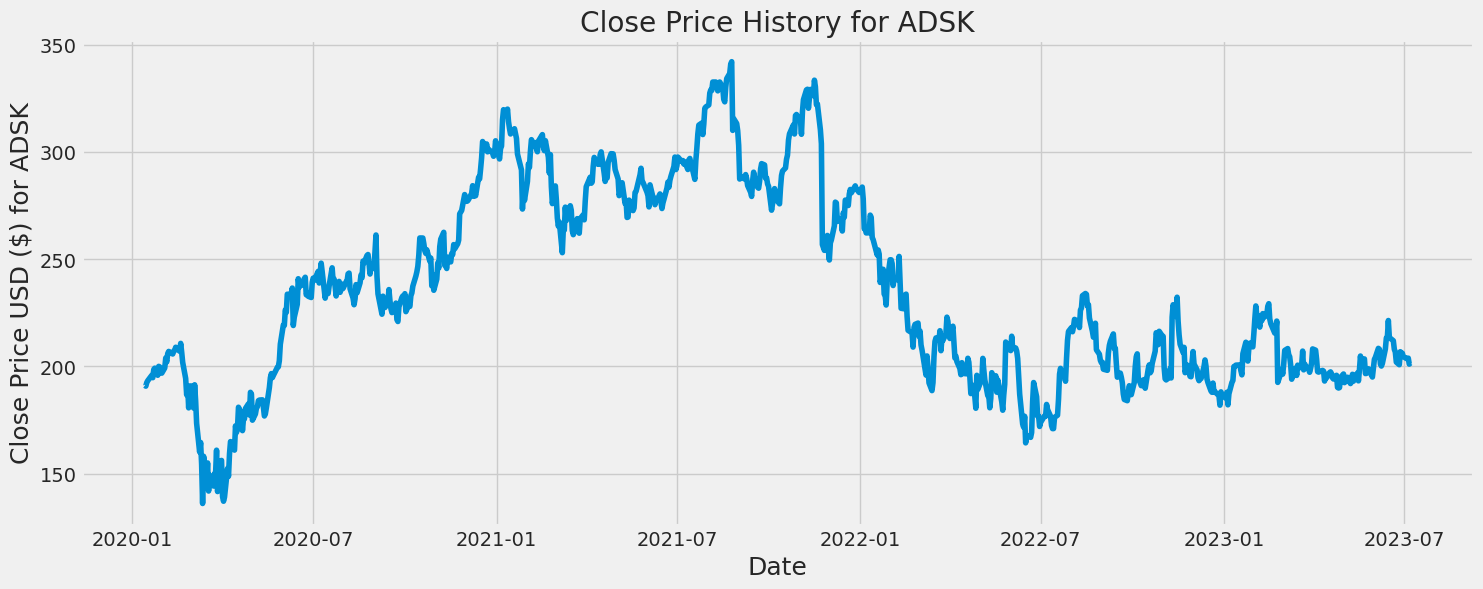

.
.
3/3 [==============================] - 1s 28ms/step


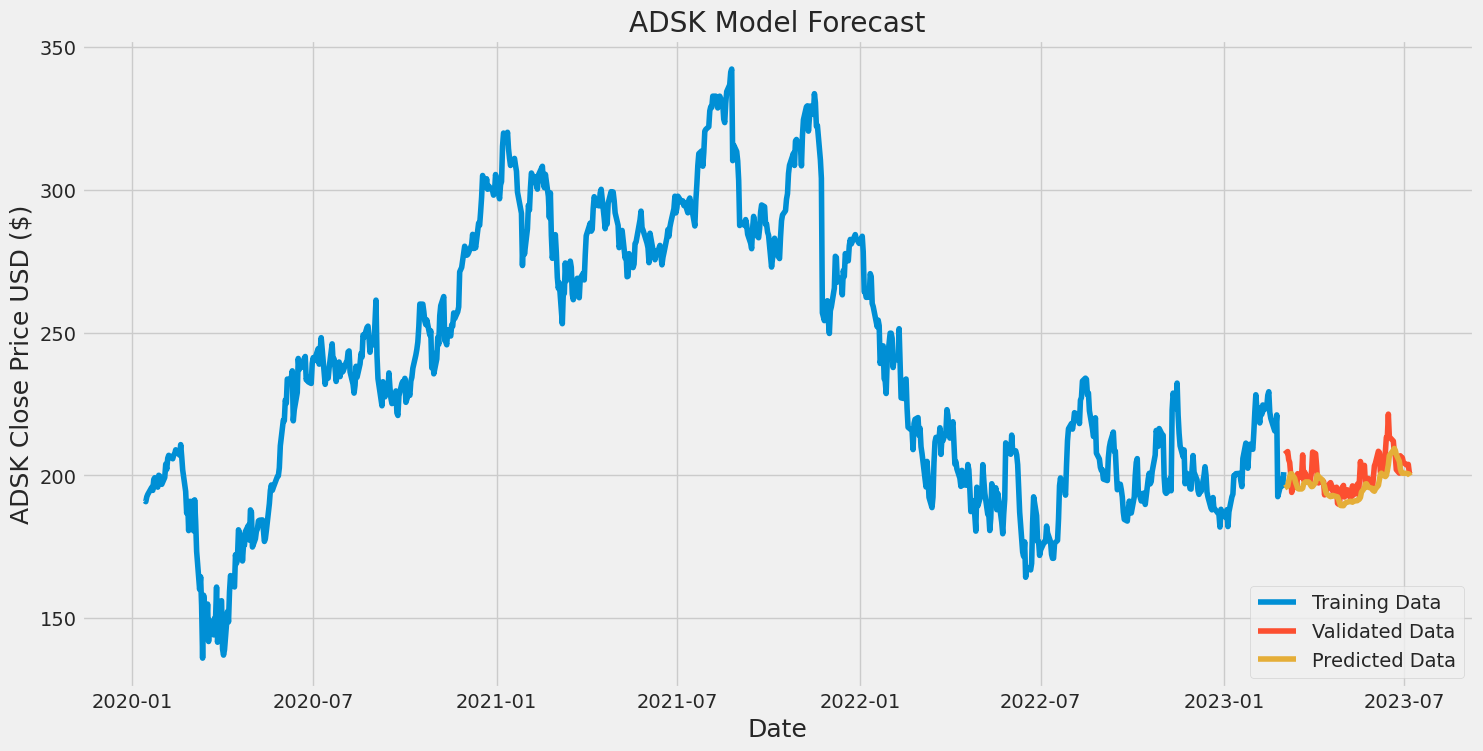

Test RMSE: 5.792


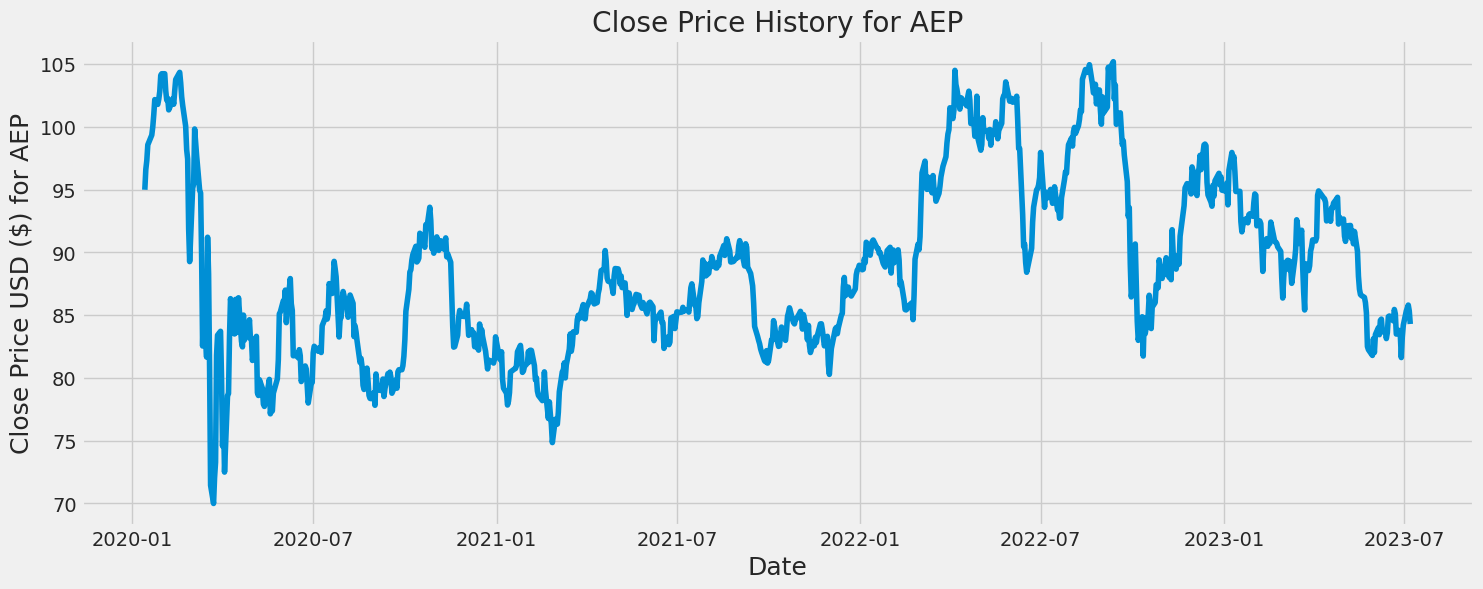

.
.
3/3 [==============================] - 1s 32ms/step


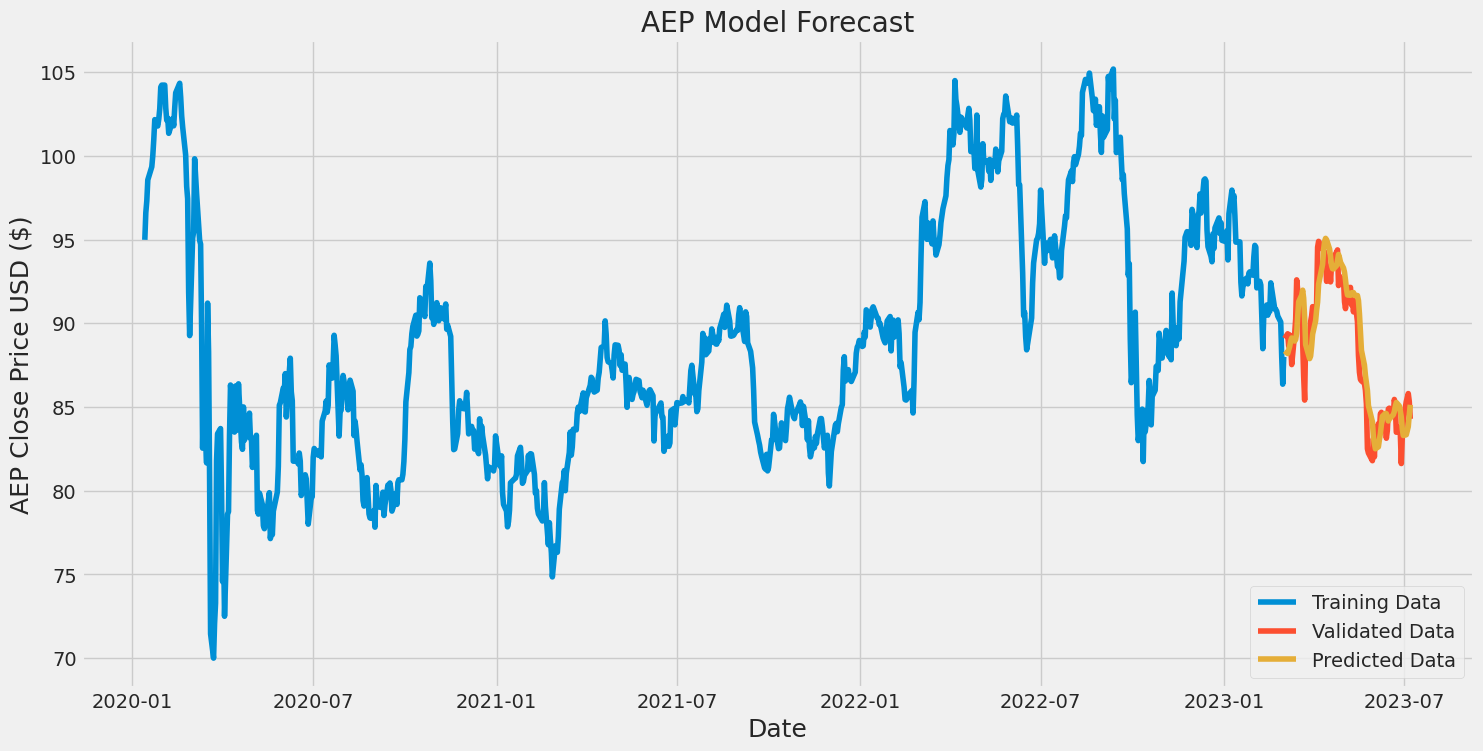

Test RMSE: 1.643


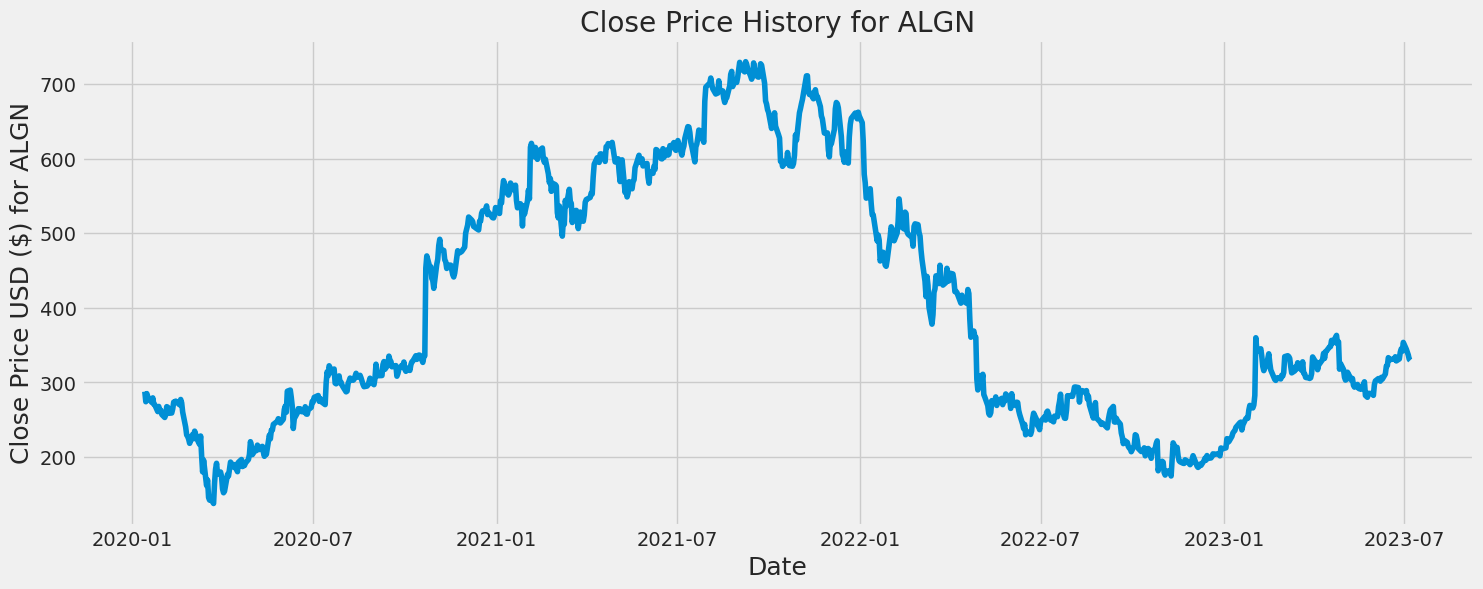

.
.
3/3 [==============================] - 1s 30ms/step


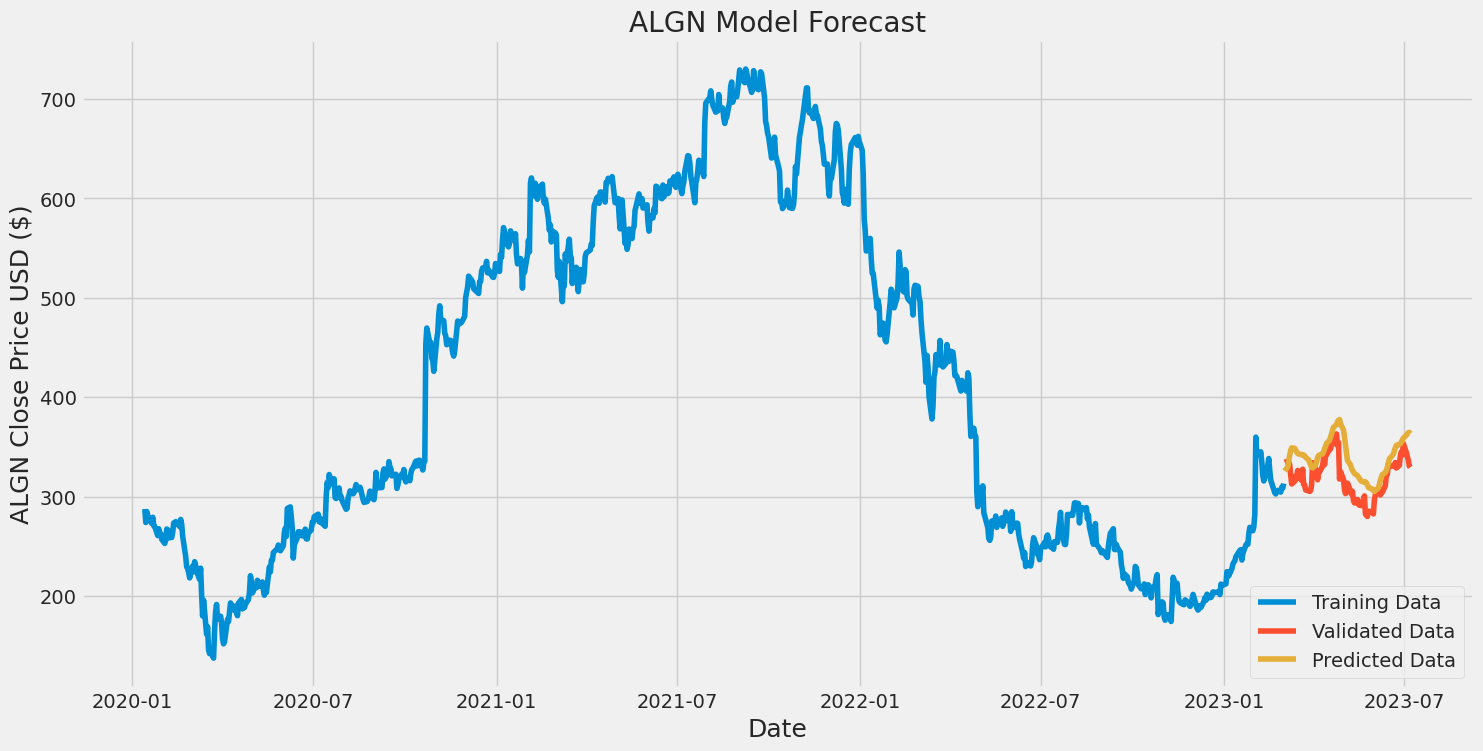

Test RMSE: 23.776


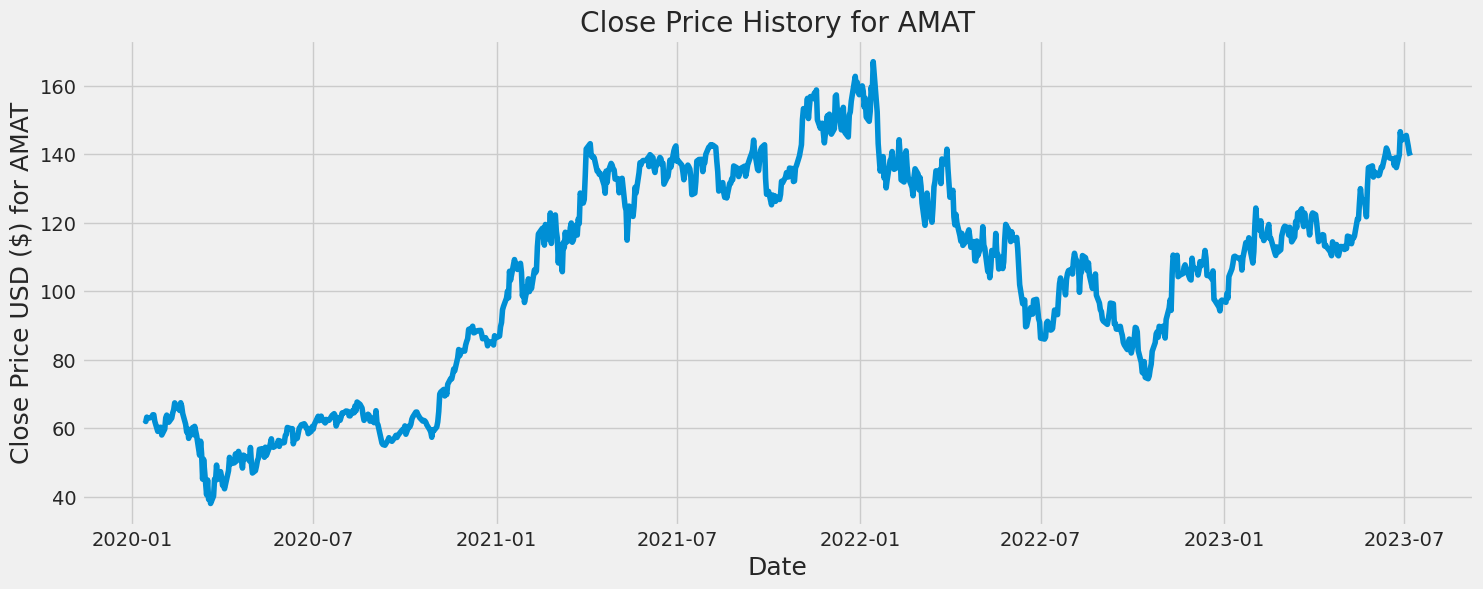

.
.
3/3 [==============================] - 1s 31ms/step


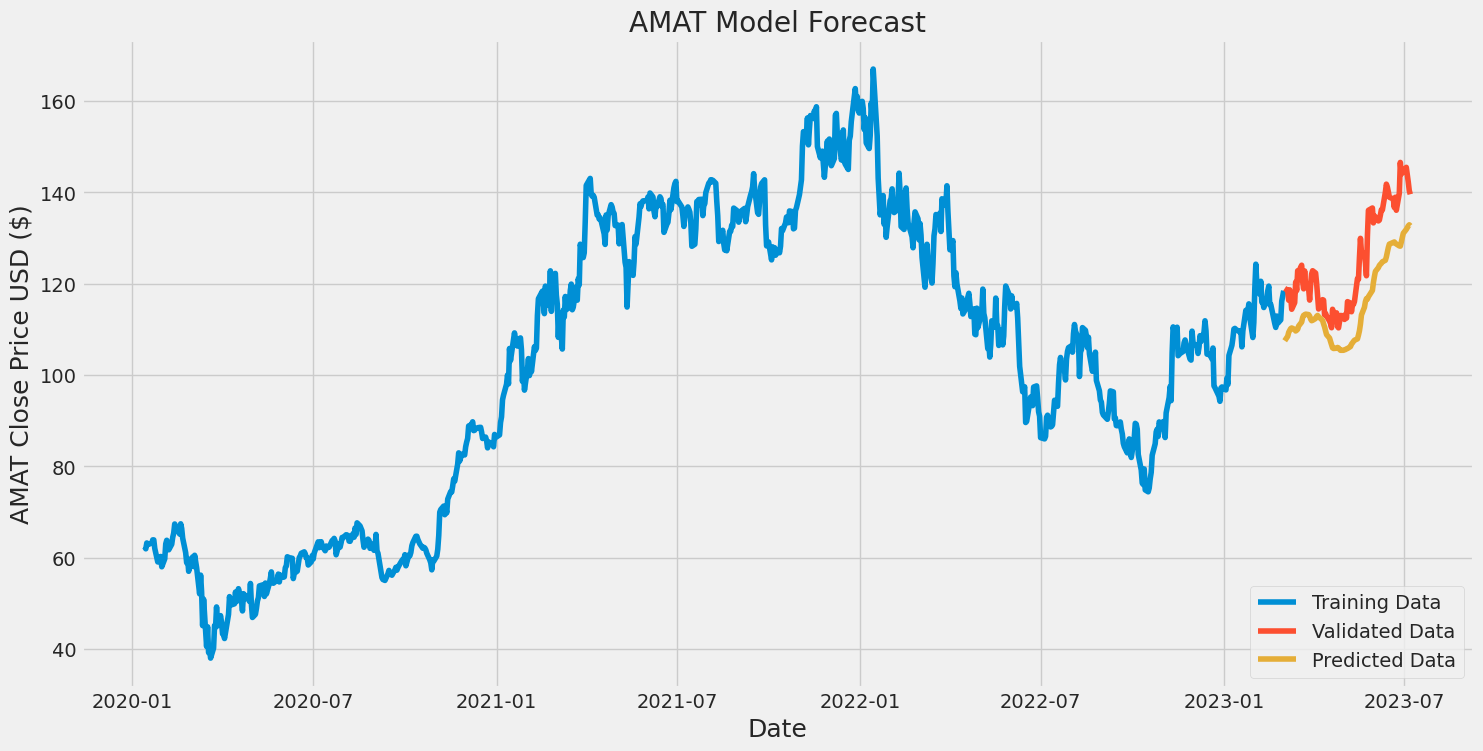

Test RMSE: 10.141


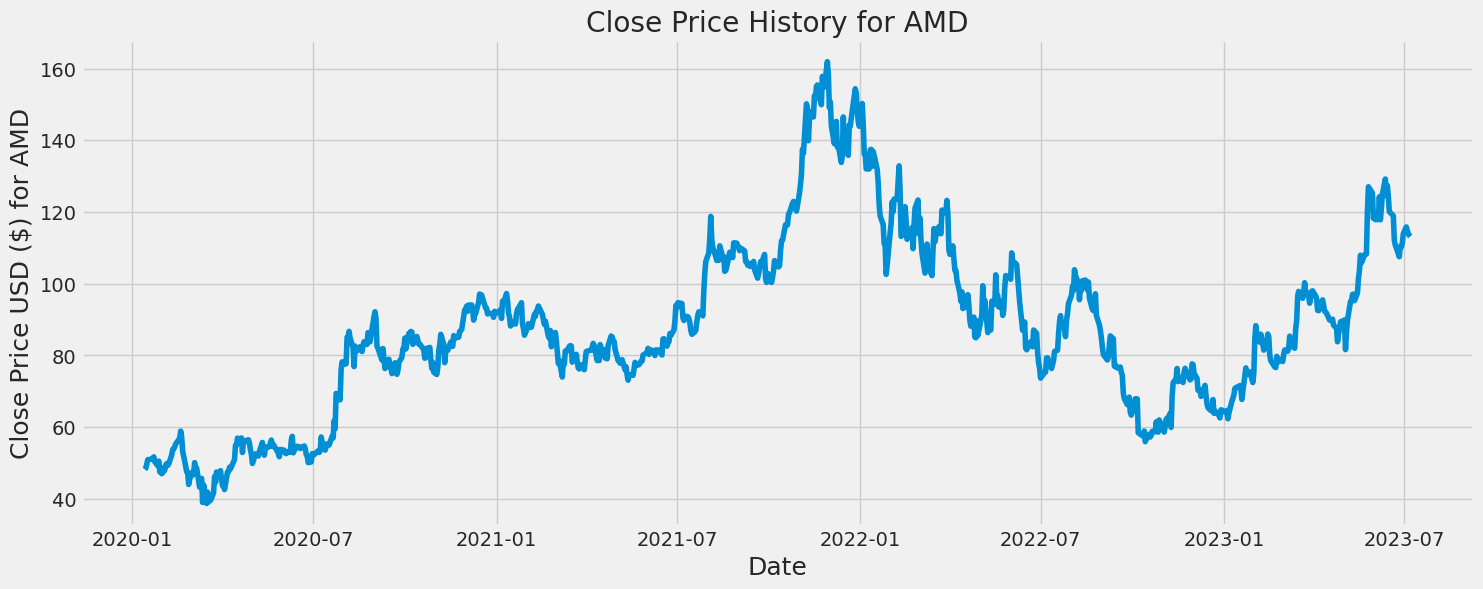

.
.
3/3 [==============================] - 1s 36ms/step


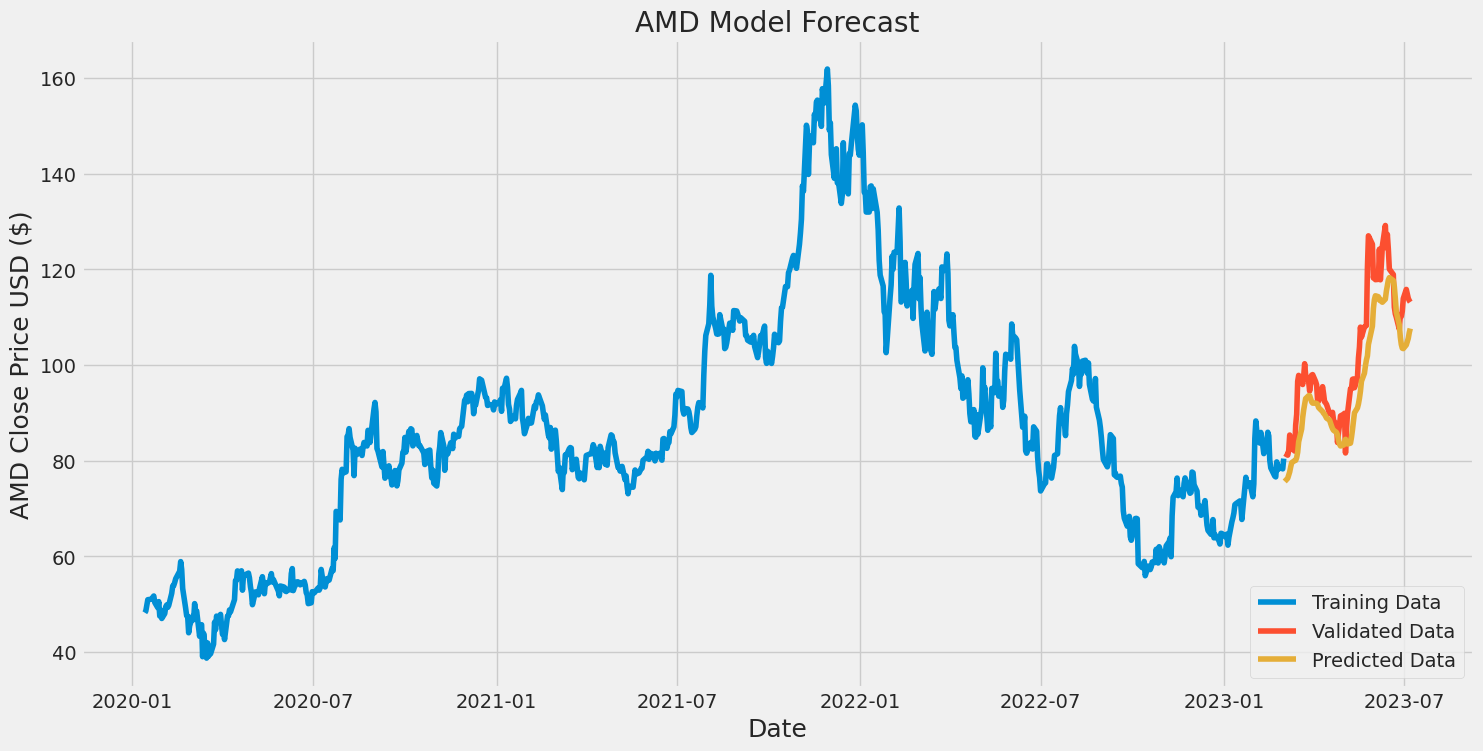

Test RMSE: 7.743


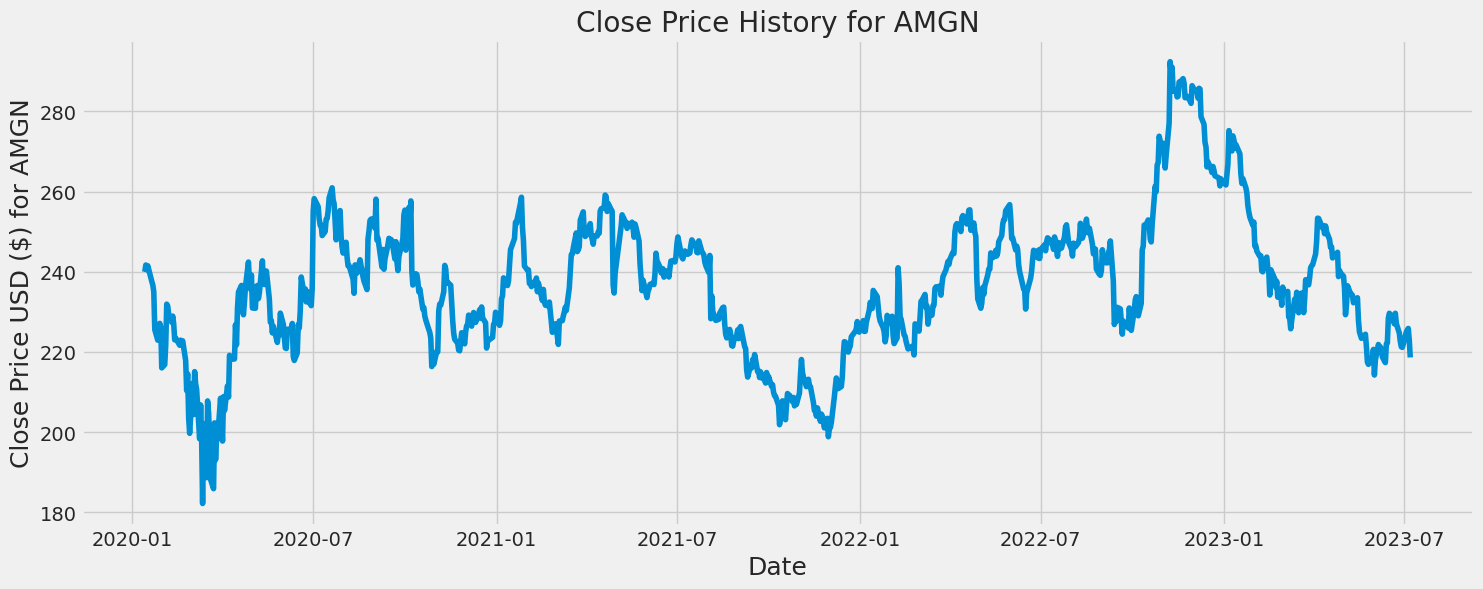

.
.
3/3 [==============================] - 1s 31ms/step


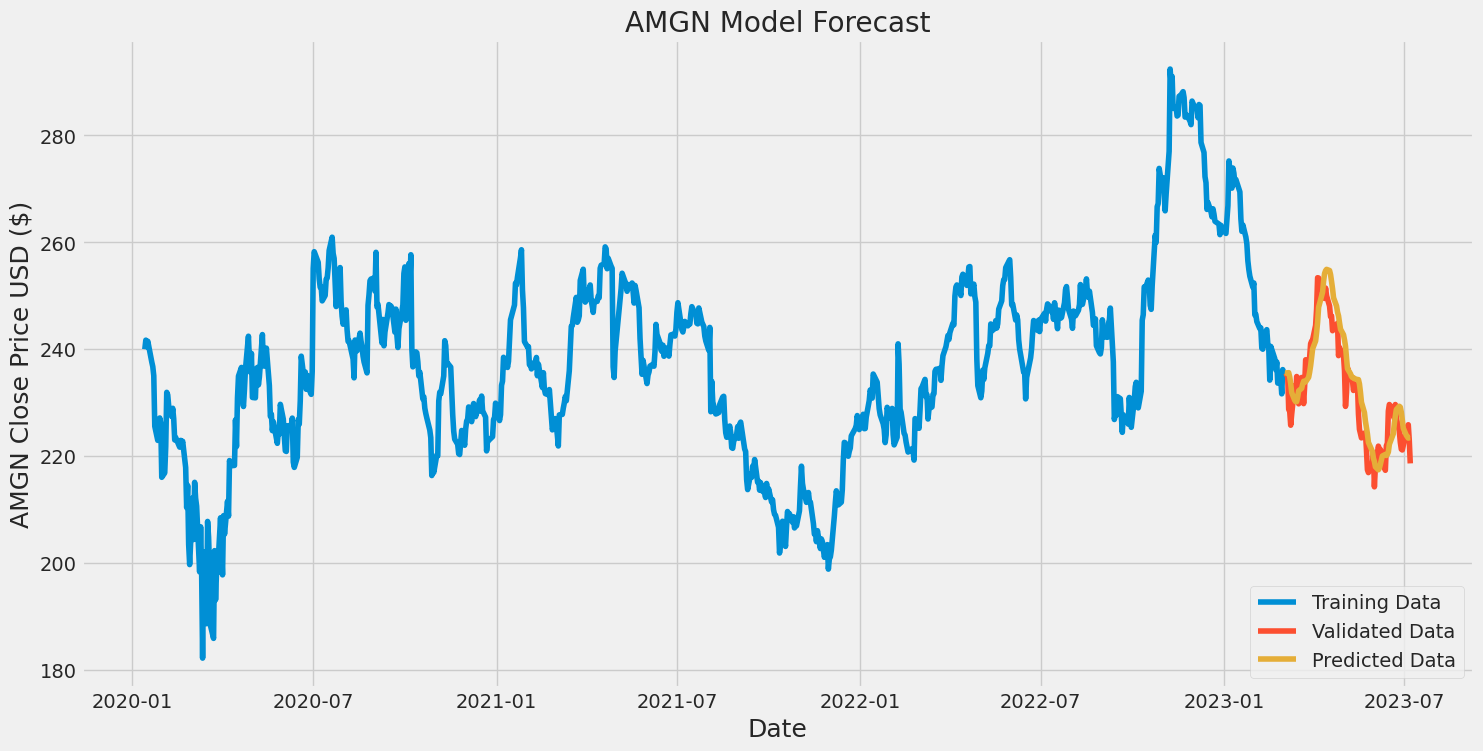

Test RMSE: 4.557


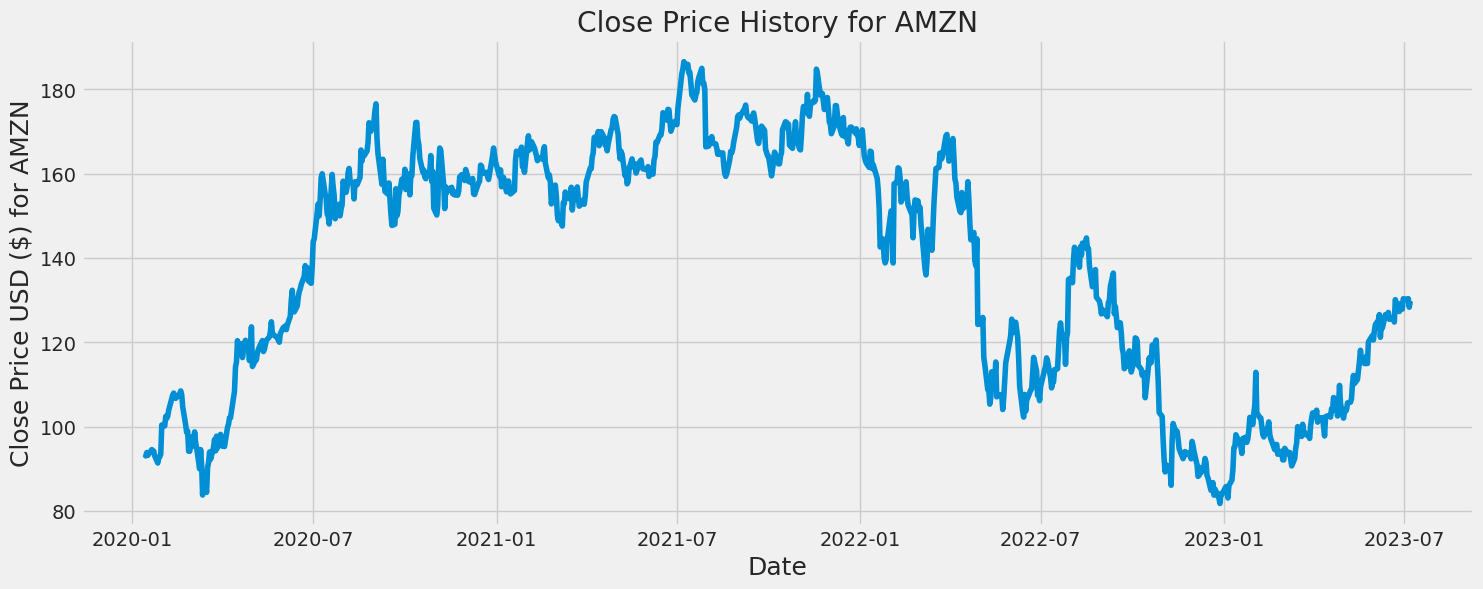

.
.
3/3 [==============================] - 1s 34ms/step


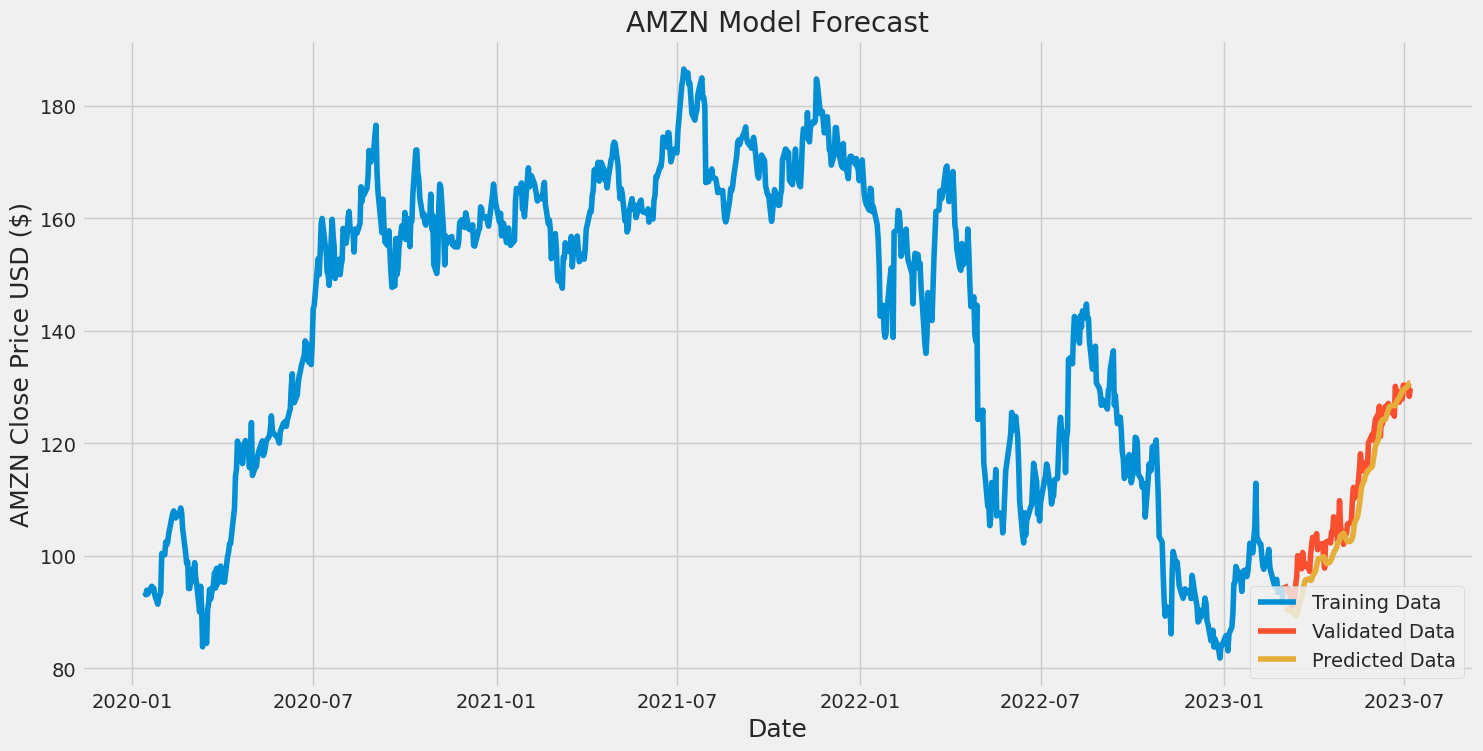

Test RMSE: 3.955


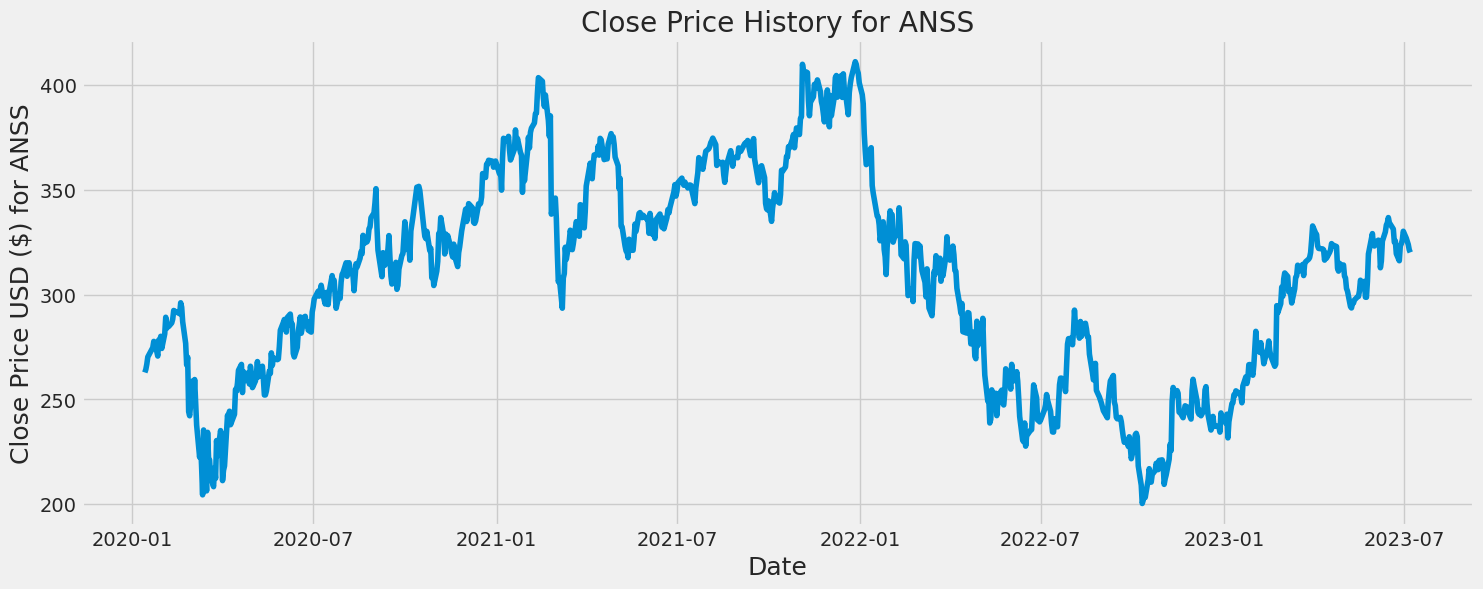

.
.
3/3 [==============================] - 1s 31ms/step


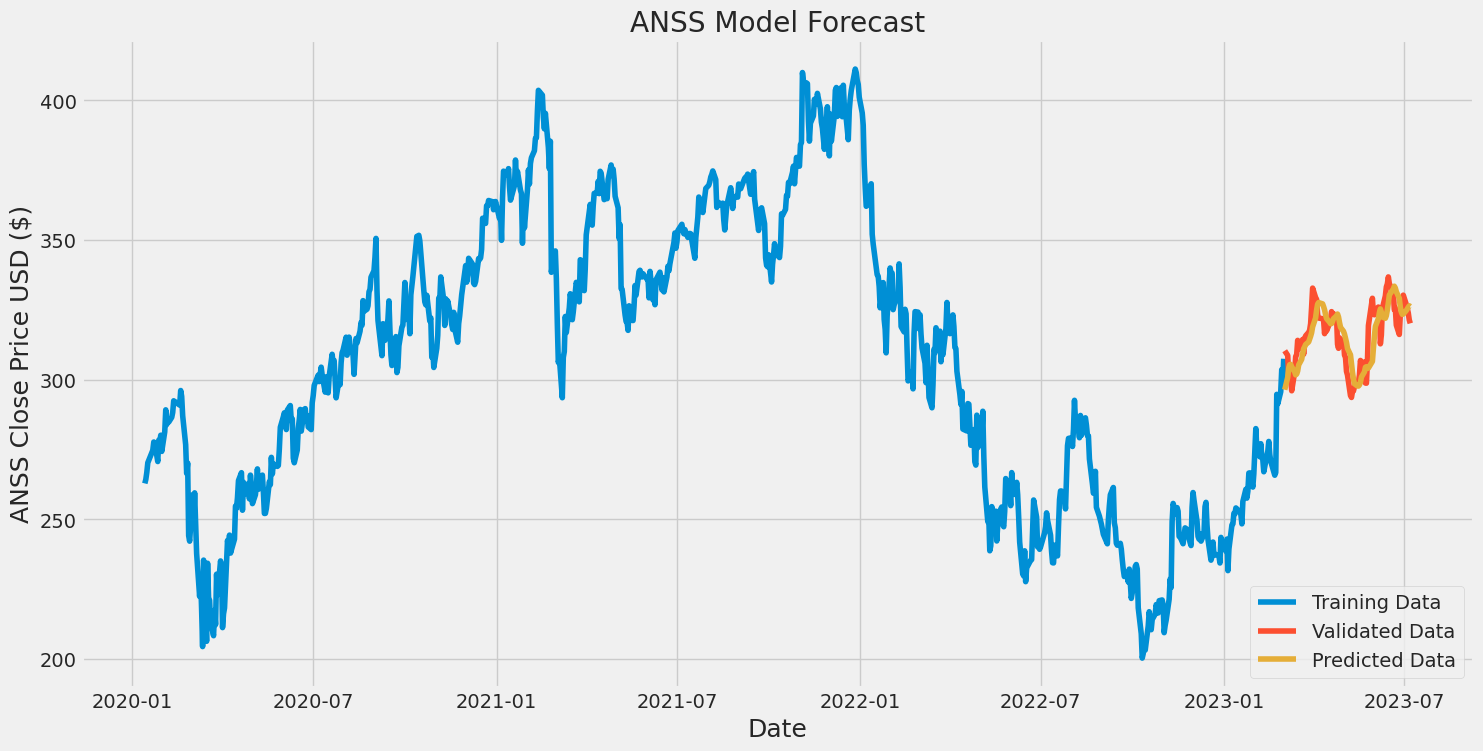

Test RMSE: 7.349


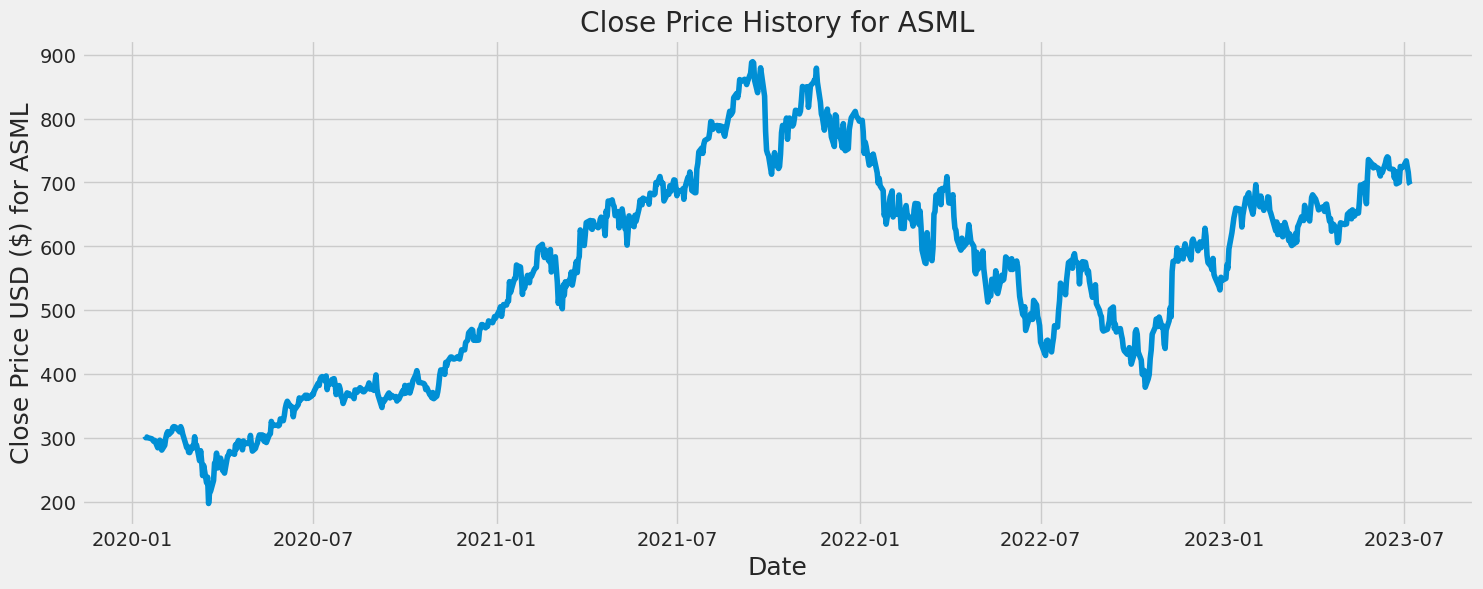

.
.
3/3 [==============================] - 1s 31ms/step


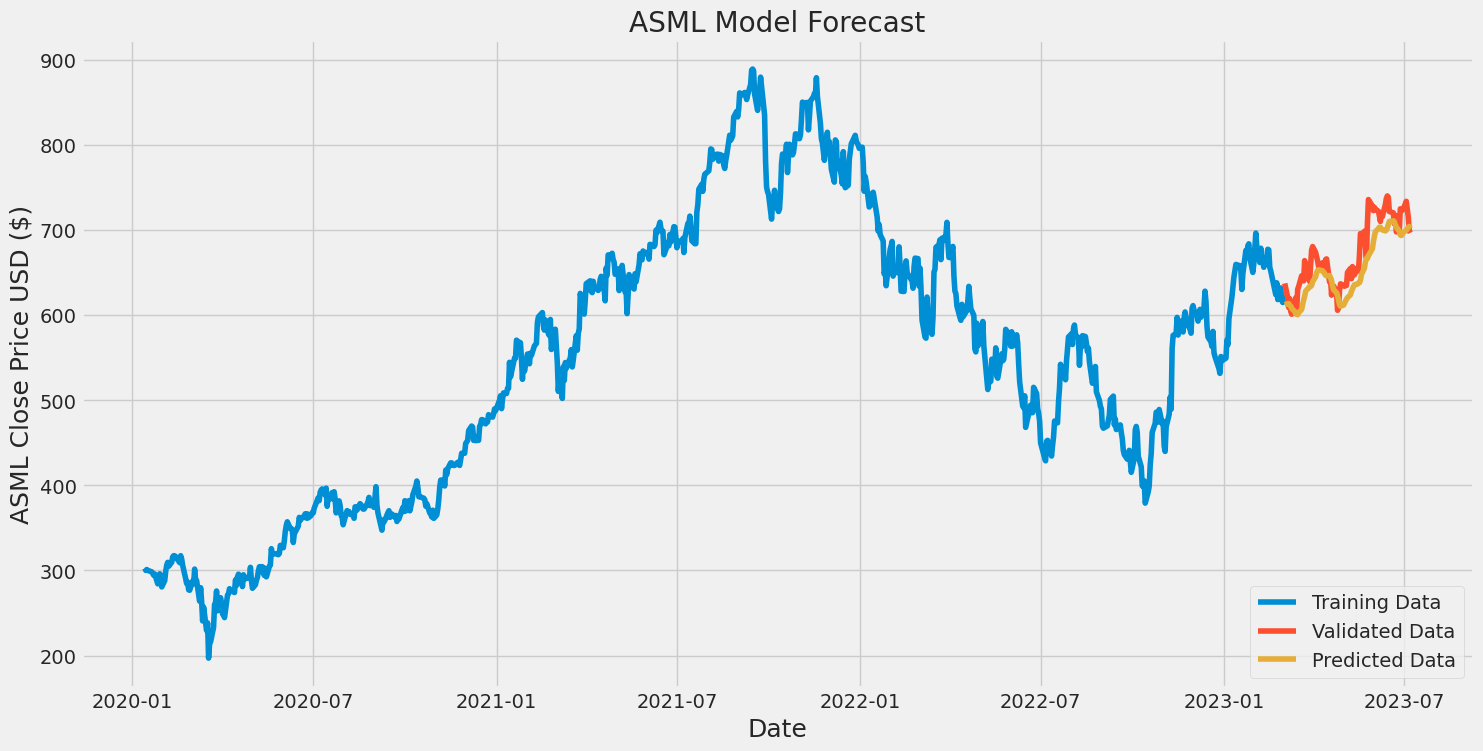

Test RMSE: 24.681


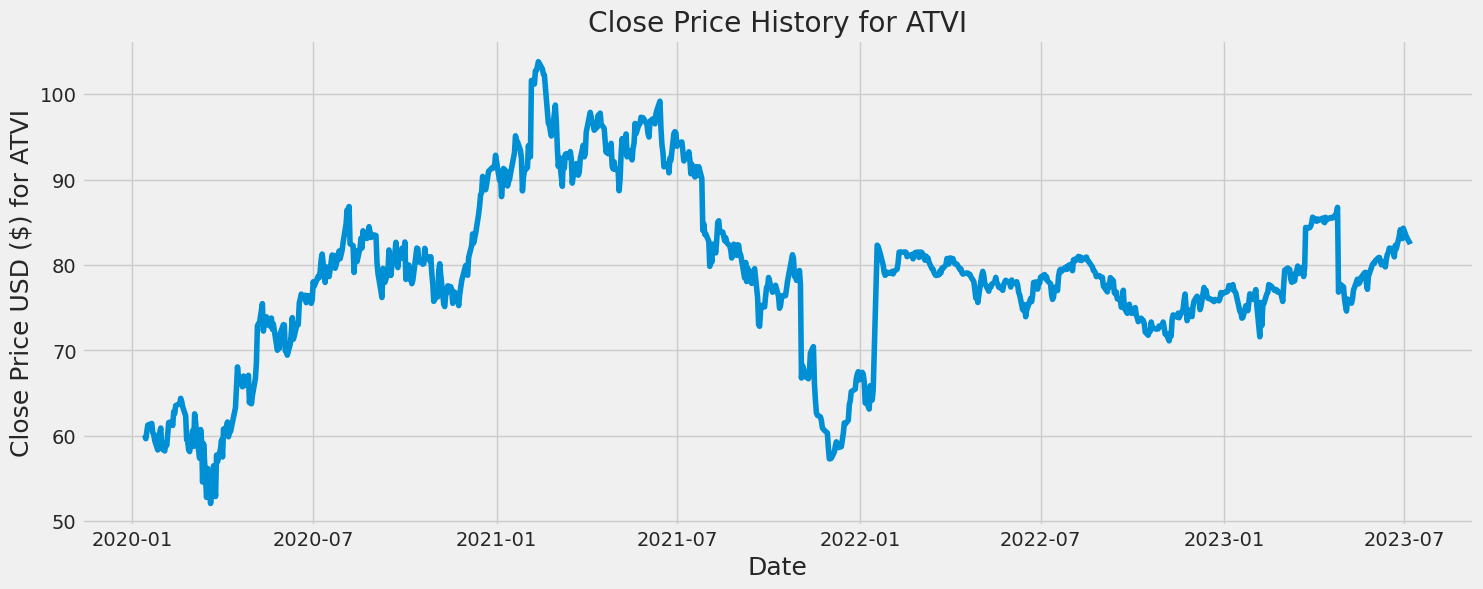

.
.
3/3 [==============================] - 1s 34ms/step


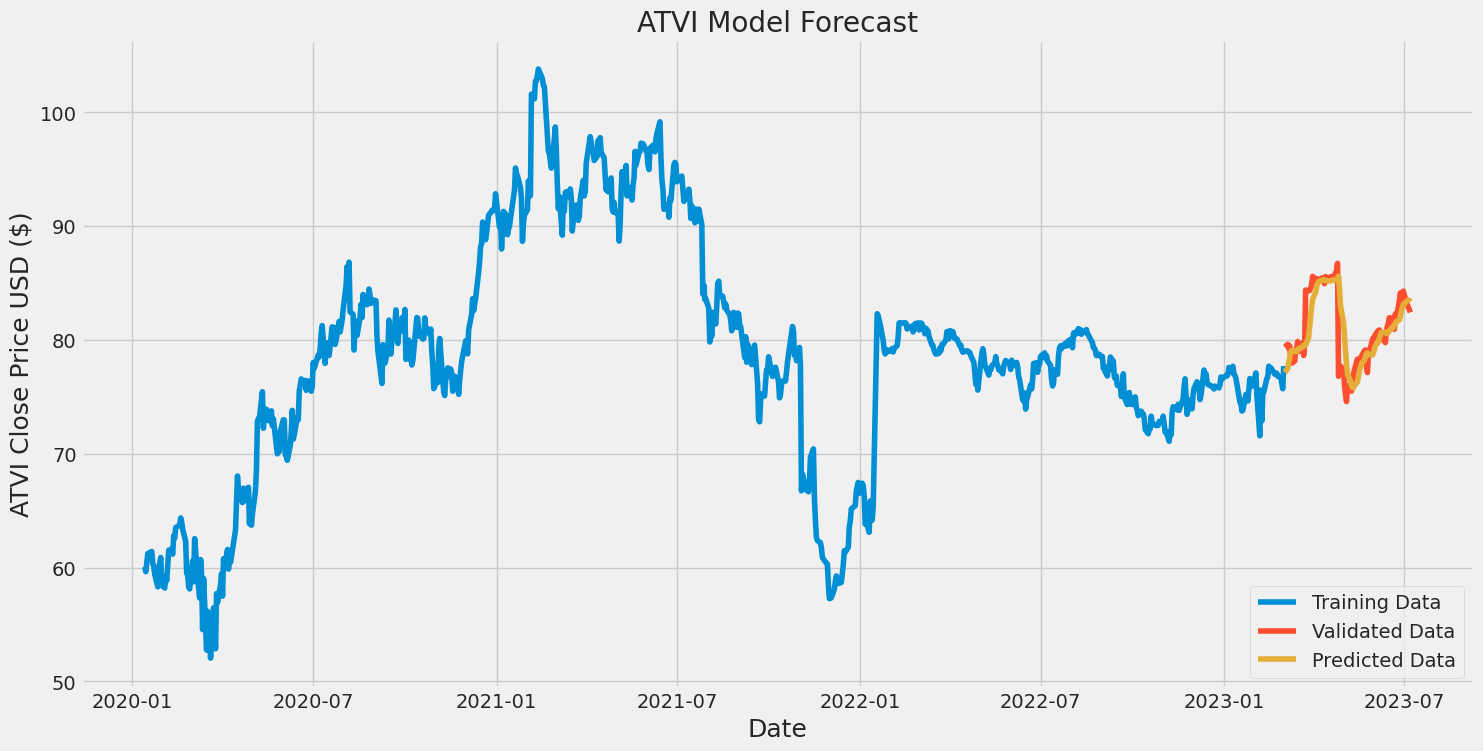

Test RMSE: 1.976


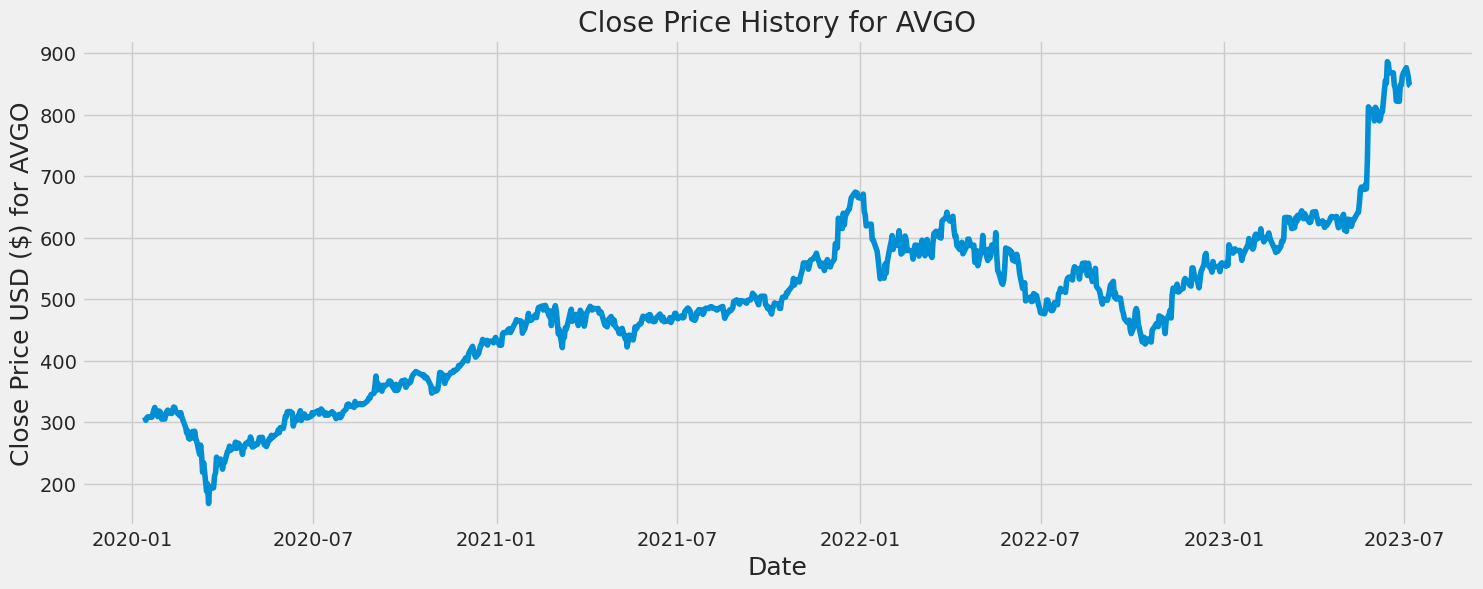

.
.
3/3 [==============================] - 1s 29ms/step


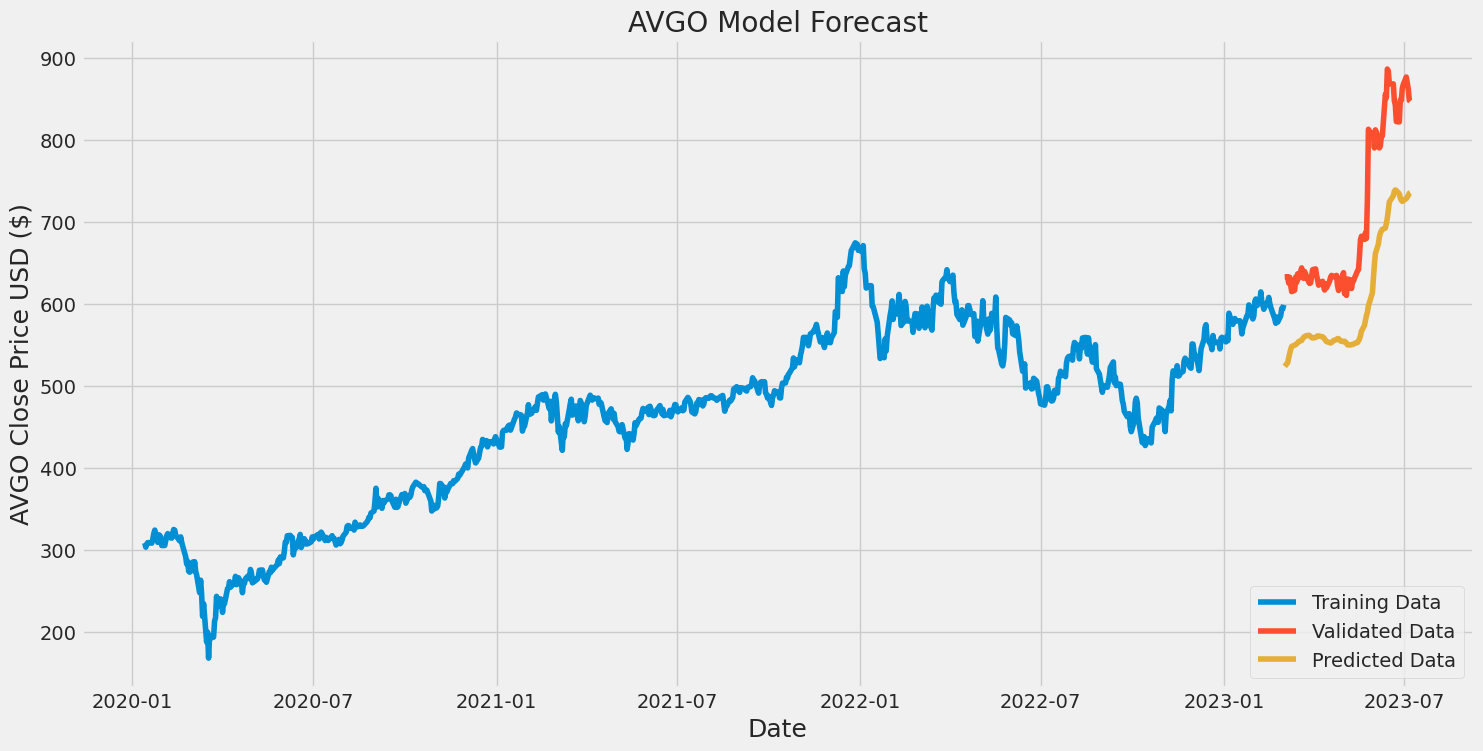

Test RMSE: 103.514
{'AAPL': 8.981541762839893, 'ADBE': 35.70997925272049, 'ADI': 4.6175583284792925, 'ADP': 3.4006422635671716, 'ADSK': 5.792441503545032, 'AEP': 1.6425059511945546, 'ALGN': 23.776384599212737, 'AMAT': 10.141434134343577, 'AMD': 7.743344120914525, 'AMGN': 4.556623091884019, 'AMZN': 3.9547385498811716, 'ANSS': 7.348888150945815, 'ASML': 24.681071519916205, 'ATVI': 1.976436214980014, 'AVGO': 103.51361344029861}


In [86]:
stock_list = ['AMZN','TSLA','NVDA','GOOG','MSFT']
Symbols = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN', 'AMAT',
    'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO'
]
TEST_DATA_LENGTH = 70
start_date = '2020-01-01'
error_scores = {}
print("Let us evaluate for all stocks starting with 'A' in NASDAQ")
for stock in Symbols:
    df = collect_data(stock) #Collect the data
    plot_close_val(df, 'Close', stock) # Plot the Closing Price
    #plot_close_val(df, 'Open', stock) # Plot the Opening Price
    #print(df.head()) # Print Dataframe check
    training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
    dataset=training_dataset_np
    data=training_data_df
    scaler, scaled_data = scale_the_data(training_dataset_np) #Scale the data
    x_train,y_train = split_train_dataset(training_data_len) #split the data
    lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model 
    
    x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
    
    valid = plot_predictions(stock,data,training_data_len) #plot predictions
    valid   # Show the valid and predicted prices
    
    rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
    print('Test RMSE: %.3f' % (rmse))
    #error_scores.append(rmse)
    error_scores[stock] = rmse

print(error_scores)